In [ ]:
!pip install -q -U keras-tuner
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflowjs as tfjs
import tempfile
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
import zipfile
import json
import joblib

# Data Preperation

In [ ]:
data_gabungan = pd.read_csv('/content/data_gabungan.csv')

In [ ]:
data_gabungan.head()

Unnamed: 0      Date  Close USDIDR  BI Rate  Inflasi  Close CTRA  \
0           0  Nov 2005  10022.909091    12.25    18.38  131.694067   
1           1  Dec 2005   9846.781783    12.75    17.11  150.381503   
2           2  Jan 2006   9450.995517    12.75    17.03  192.725182   
3           3  Feb 2006   9247.700000    12.75    17.92  209.171062   
4           4  Mar 2006   9142.069676    12.75    15.74  209.993940   

   Close INDF   Close ASII  Close BSDE  Close ICBP  ...  Close ACES  \
0  827.894737   897.631579     1135.45  416.052632  ...      259.25   
1  911.909091  1012.045455     1128.89  458.181818  ...      256.13   
2  904.181818  1070.000000     1121.91  454.090909  ...      252.88   
3  869.000000   999.750000     1114.50  436.500000  ...      249.50   
4  847.826087  1059.347826     1106.62  425.869565  ...      245.97   

   Close TSPC   Close SMAR  Close SMSM  Close JRPT  Close DUTI  Close EPMT  \
0  572.368421   955.789474   80.789474   75.200000  643.684211  536.112913   
1  580.000000   965.454545   77.386364   75.036363  644.545455  625.272131   
2  574.318182  1056.363636   80.568182   75.654545  785.909091  700.681829   
3  648.500000  1380.500000   78.375000   76.000000  839.500000  711.005777   
4  658.043478  1765.217391   76.358696   82.834782  816.956522  745.783232   

   Close SMCB  Close PWON  Close JSMR  
0  448.421053   15.569972     4198.71  
1  481.818182   16.993849     4159.36  
2  543.181818   16.454629     4117.52  
3  634.000000   17.089898     4073.00  
4  643.043478   18.535681     4025.63  

[5 rows x 25 columns]

In [ ]:
X = data_gabungan[['Close USDIDR', 'BI Rate', 'Inflasi']].values

Y = data_gabungan[['Close CTRA', 'Close INDF', 'Close ASII', 'Close BSDE',
                 'Close ICBP', 'Close KLBF', 'Close ITMG', 'Close JPFA',
                 'Close TLKM', 'Close ULTJ', 'Close ACES', 'Close TSPC',
                  'Close SMAR', 'Close SMSM', 'Close JRPT', 'Close DUTI',
                   'Close EPMT', 'Close SMCB', 'Close PWON', 'Close JSMR']].values

In [ ]:
# 70% Train, 30% Val
total_ukuran_data = len(X)
ukuran_data_pelatihan = int(0.80 * total_ukuran_data)

X_Latih, Y_Latih = X[:ukuran_data_pelatihan], Y[:ukuran_data_pelatihan]
X_Validasi, Y_Validasi = X[ukuran_data_pelatihan:], Y[ukuran_data_pelatihan:]

skala_X = StandardScaler()
X_Latih_Standarisasi = skala_X.fit_transform(X_Latih)
X_Validasi_Standarisasi = skala_X.transform(X_Validasi)

skala_Y = StandardScaler()
Y_Latih_Standarisasi = skala_Y.fit_transform(Y_Latih)
Y_Validasi_Standarisasi = skala_Y.transform(Y_Validasi)

# Modeling

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Set up TPU strategy
    print("Running on TPU")
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy if TPU is not available
    print("Running on GPU/CPU")


Running on GPU/CPU


In [ ]:
def model_builder(hp):
  with strategy.scope():
      model = tf.keras.Sequential()
      model.add(tf.keras.layers.Input(shape=(X_Latih.shape[1],)))
      num_layers = hp.Int('num_layers', min_value=2, max_value=6, step=1)
      for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=16, max_value=512, step=16)
        regularizer = hp.Float(f'kernel_regularizer_{i}', min_value=1e-6, max_value=1e-3, sampling='log')


        model.add(tf.keras.layers.Dense(units=units,
                                        activation='relu',
                                        kernel_regularizer=regularizers.l2(regularizer),
                                        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.6, step=0.1)))

      model.add(tf.keras.layers.Dense(20, activation='linear'))

      # Fine-tune the optimizer
      optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adamw'])

      if optimizer_choice == 'adam':
          hp_learning_rate = hp.Float('adam_learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
          optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

      elif optimizer_choice == 'sgd':
          hp_learning_rate = hp.Float('sgd_learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
          hp_momentum = hp.Float('sgd_momentum', min_value=0.0, max_value=0.9, step=0.1)
          optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=hp_momentum)

      elif optimizer_choice == 'rmsprop':
          hp_learning_rate = hp.Float('rmsprop_learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
          hp_rho = hp.Float('rmsprop_rho', min_value=0.7, max_value=0.99, step=0.05)
          optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate, rho=hp_rho)

      elif optimizer_choice == 'adamw':
          hp_learning_rate = hp.Float('adamw_learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
          hp_weight_decay = hp.Float('adamw_weight_decay', min_value=1e-6, max_value=1e-2, sampling='log')
          optimizer = tf.keras.optimizers.AdamW(learning_rate=hp_learning_rate, weight_decay=hp_weight_decay)

      model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=2,
                     directory='TunnerV3',
                     project_name='stock_price_prediction',)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              restore_best_weights=True
                                              )

In [ ]:
tuner.search(
    X_Latih_Standarisasi,
    Y_Latih_Standarisasi,
    validation_data=(X_Validasi_Standarisasi, Y_Validasi_Standarisasi),
    epochs=1000,
    callbacks=[stop_early],

)

Trial 359 Complete [00h 00m 24s]
val_loss: 0.42412471771240234

Best val_loss So Far: 0.33094531297683716
Total elapsed time: 01h 08m 24s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print("Best Hyperparameters:")
for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
num_layers: 2
units_0: 32
kernel_regularizer_0: 8.197271487080962e-05
dropout_0: 0.5
units_1: 96
kernel_regularizer_1: 0.00039201016291001234
dropout_1: 0.4
optimizer: adamw
adam_learning_rate: 0.0007548424422471007
sgd_learning_rate: 0.0042465732268189465
sgd_momentum: 0.5
units_2: 240
kernel_regularizer_2: 0.0001231349334340605
dropout_2: 0.5
rmsprop_learning_rate: 0.0001277452723592625
rmsprop_rho: 0.75
adamw_learning_rate: 0.001996244203457638
adamw_weight_decay: 0.0002531468528178742
units_3: 288
kernel_regularizer_3: 0.00016536037279401007
dropout_3: 0.4
units_4: 512
kernel_regularizer_4: 2.8145658007421746e-05
dropout_4: 0.2
units_5: 400
kernel_regularizer_5: 2.3113485483448592e-05
dropout_5: 0.5
tuner/epochs: 100
tuner/initial_epoch: 50
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0315


In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 96)                  │           3,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 96)                  │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 20)                  │           1,940 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,748 (22.45 KB)

 Trainable params: 5,492 (21.45 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
checkpoint_filepath = 'best_model_v3.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
history = model.fit(X_Latih_Standarisasi, Y_Latih_Standarisasi,
                    validation_data=(X_Validasi_Standarisasi, Y_Validasi_Standarisasi),
                    epochs=1000,
                    batch_size=32,
                    callbacks=[checkpoint])

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 3.0932 - mae: 1.3676 - val_loss: 0.7506 - val_mae: 0.6662
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4024 - mae: 1.2206 - val_loss: 0.6961 - val_mae: 0.6411
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0352 - mae: 1.1152 - val_loss: 0.6524 - val_mae: 0.6196
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9524 - mae: 1.0985 - val_loss: 0.6247 - val_mae: 0.6051
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6986 - mae: 1.0192 - val_loss: 0.6172 - val_mae: 0.6012
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5843 - mae: 0.9788 - val_loss: 0.6266 - val_mae: 0.6050
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3363 - mae: 0.9125 - val_loss: 0.6367 - val_mae: 0.6092
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3740 - mae: 0.9057 - val_loss: 0.6385 - val_mae: 0.6104
Epoch 9/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2338 - 

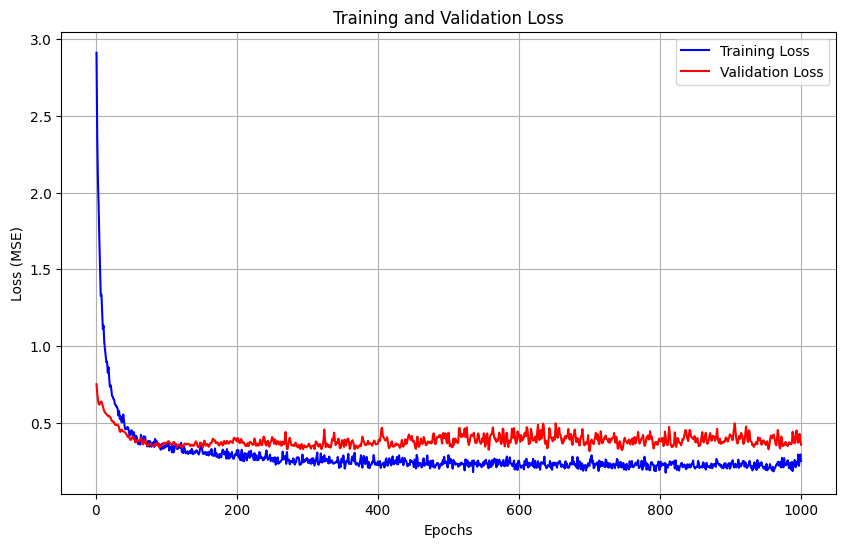

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig("train.png", dpi=300)
plt.show()

In [ ]:
best_model_v5 = tf.keras.models.load_model(checkpoint_filepath)

In [ ]:
best_model_v5.evaluate(X_Validasi_Standarisasi, Y_Validasi_Standarisasi)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3034 - mae: 0.4101 


[0.31415173411369324, 0.420462429523468]

In [ ]:
best_model_1 = tf.keras.models.load_model("/content/best_model_v1.keras")
best_model_2 = tf.keras.models.load_model("/content/best_model_v2.keras")
best_model_3 = tf.keras.models.load_model("/content/best_model_v3.keras")

print(best_model_1.evaluate(X_Validasi_Standarisasi, Y_Validasi_Standarisasi))
print(best_model_2.evaluate(X_Validasi_Standarisasi, Y_Validasi_Standarisasi))
print(best_model_3.evaluate(X_Validasi_Standarisasi, Y_Validasi_Standarisasi))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3866 - mae: 0.4856  
[0.40716877579689026, 0.5016831755638123]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3353 - mae: 0.4614  
[0.34657105803489685, 0.47168871760368347]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3034 - mae: 0.4101  
[0.31415173411369324, 0.420462429523468]


In [ ]:
Y_pred_1 = best_model_1(X_Validasi_Standarisasi).numpy()
Y_pred_2 = best_model_2(X_Validasi_Standarisasi).numpy()
Y_pred_3 = best_model_3(X_Validasi_Standarisasi).numpy()

# Inverse transform the predictions and actual values to the original scale
Y_pred_1 = skala_Y.inverse_transform(Y_pred_1)
Y_pred_2 = skala_Y.inverse_transform(Y_pred_2)
Y_pred_3 = skala_Y.inverse_transform(Y_pred_3)
Y_Validasi = skala_Y.inverse_transform(Y_Validasi_Standarisasi)

num_stocks = Y_Validasi.shape[1]

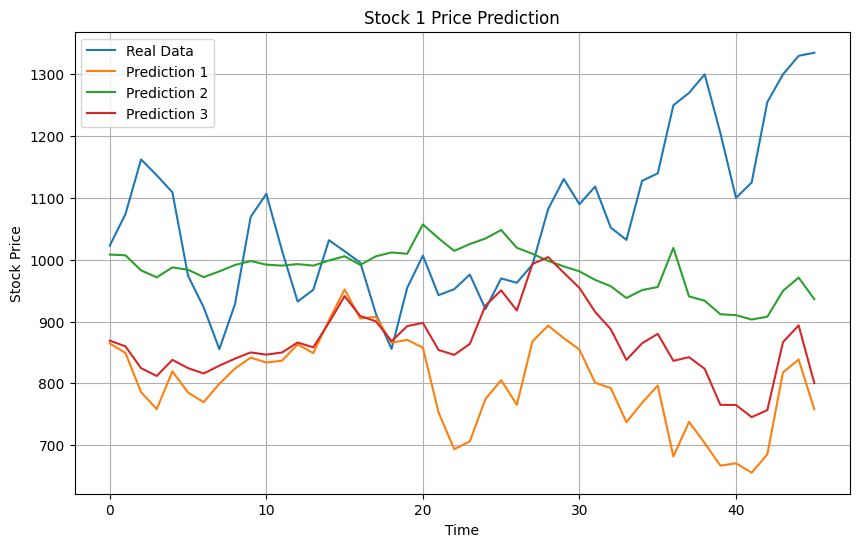

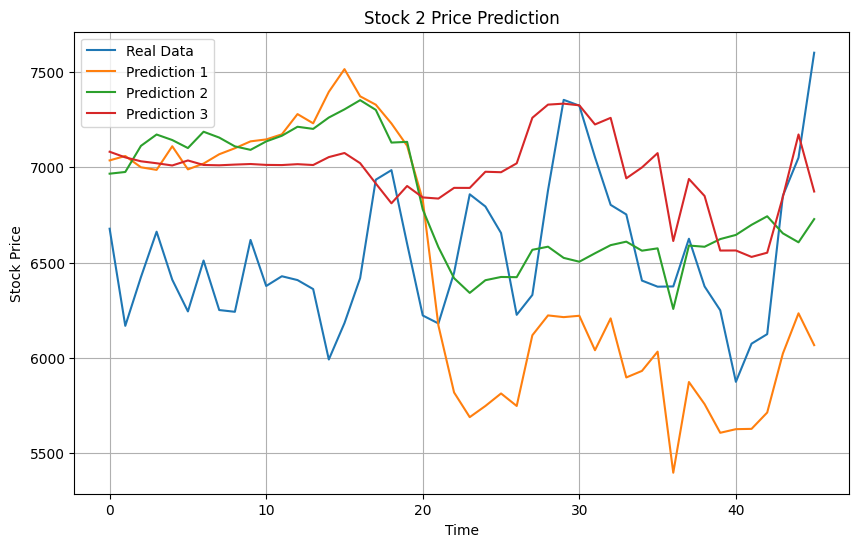

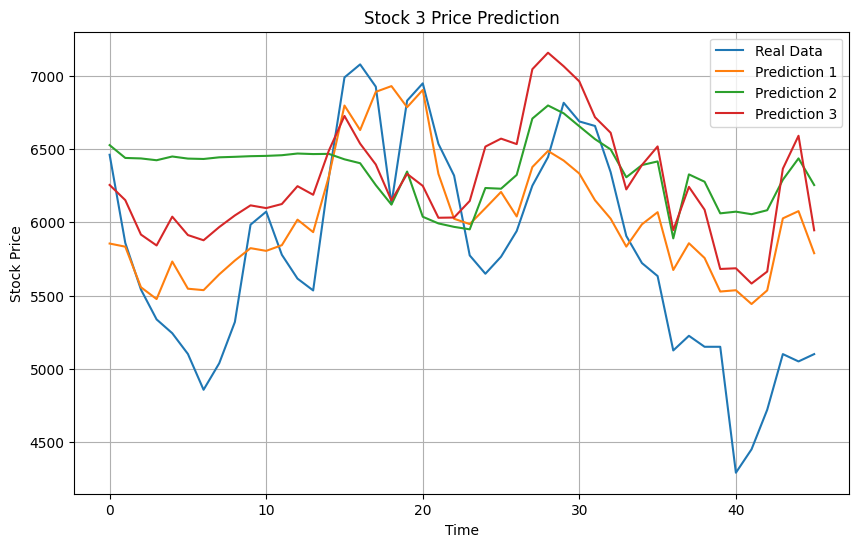

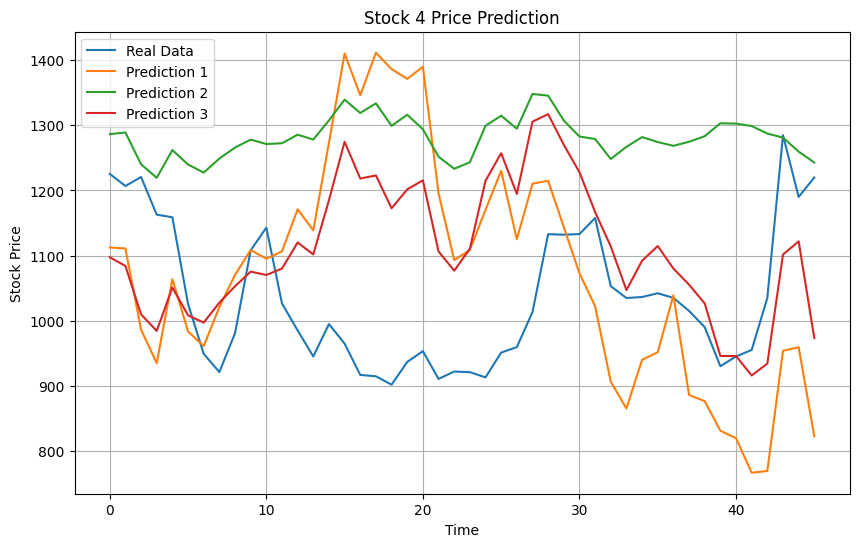

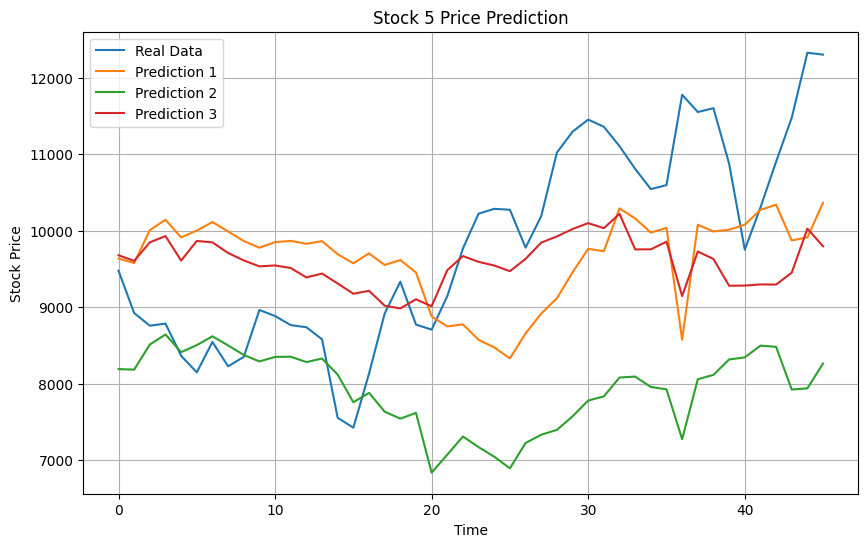

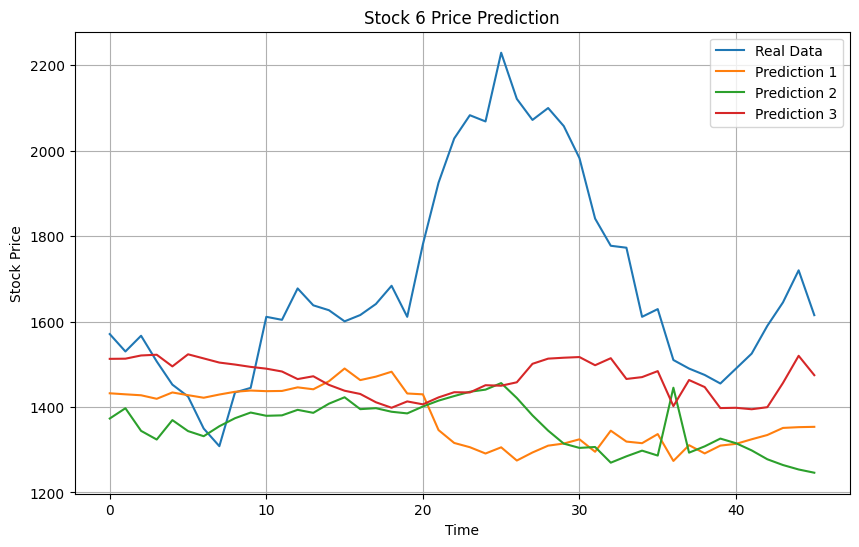

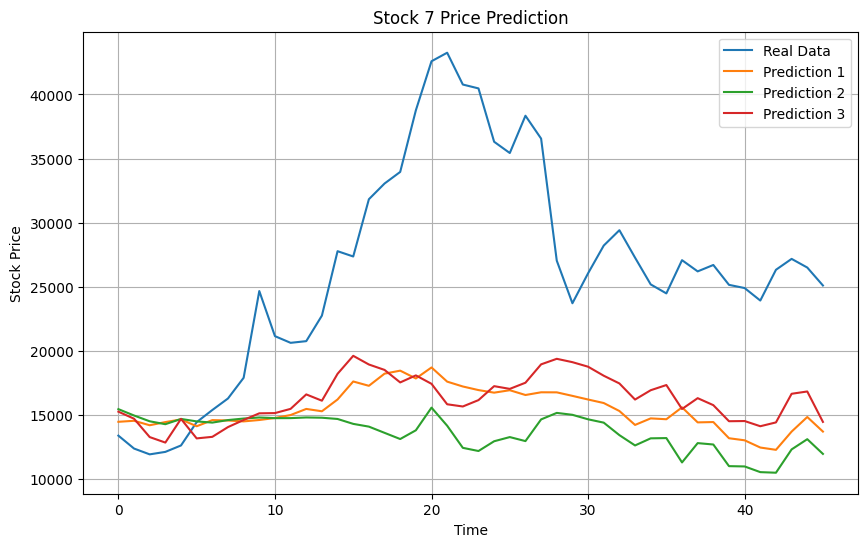

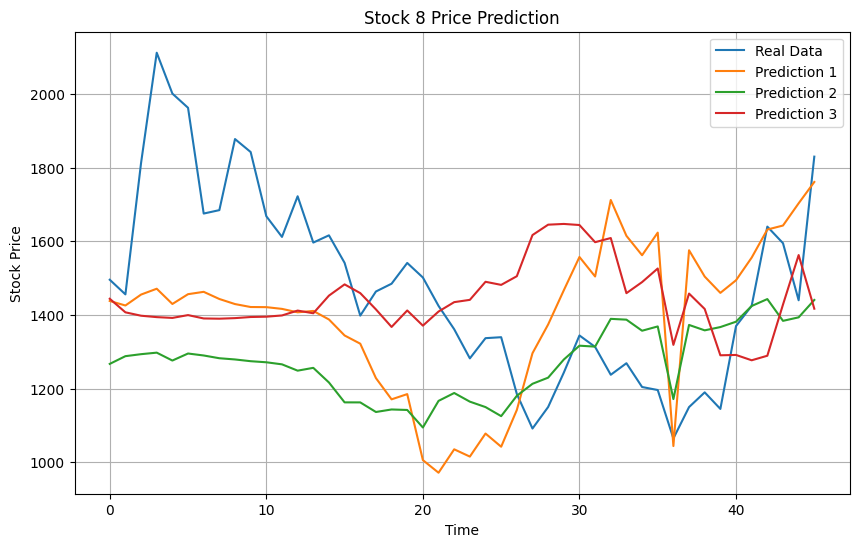

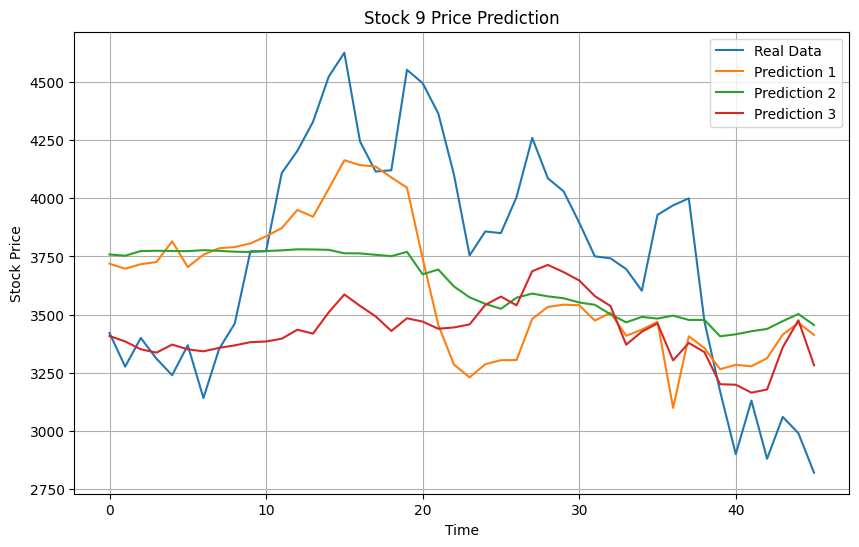

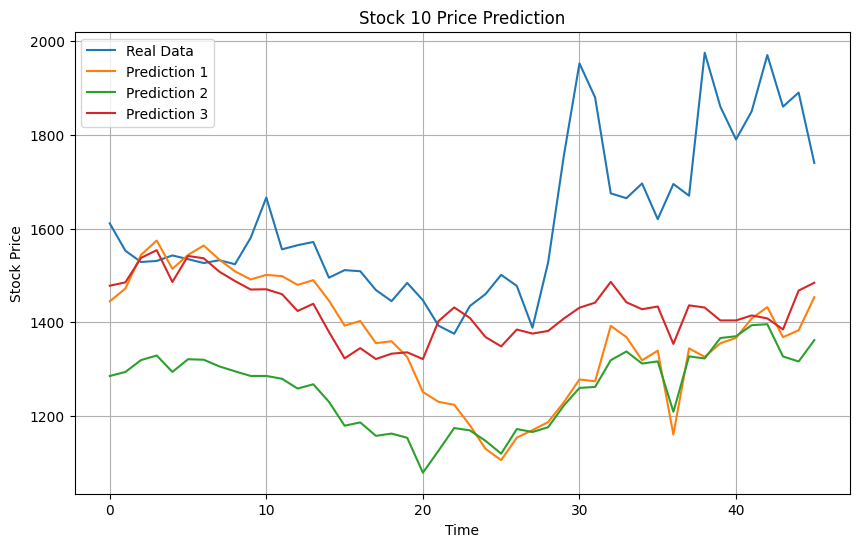

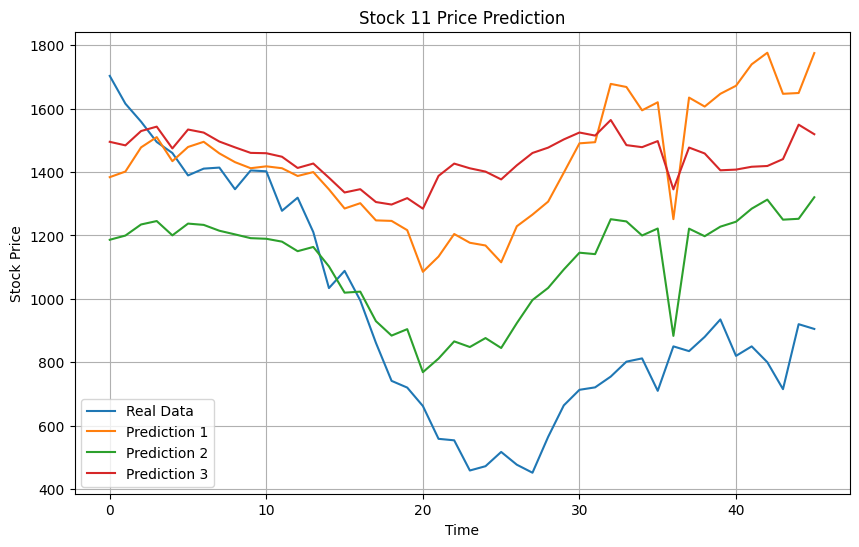

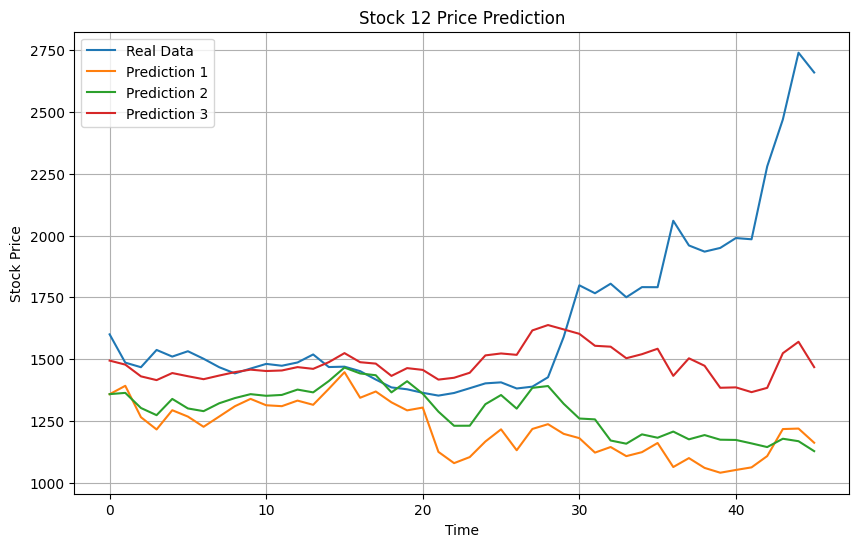

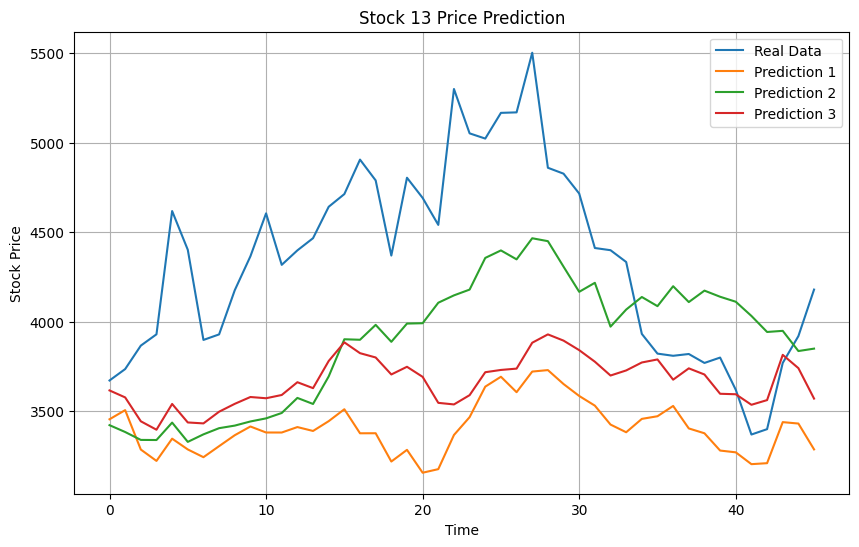

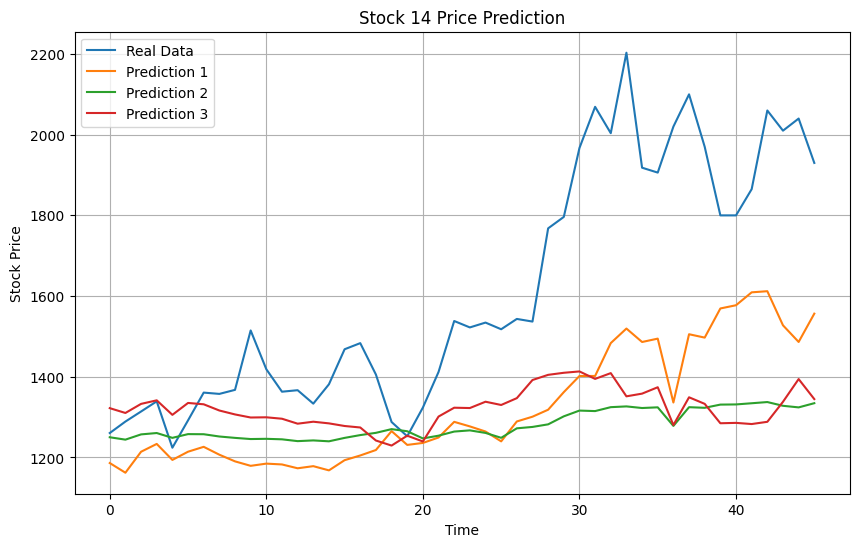

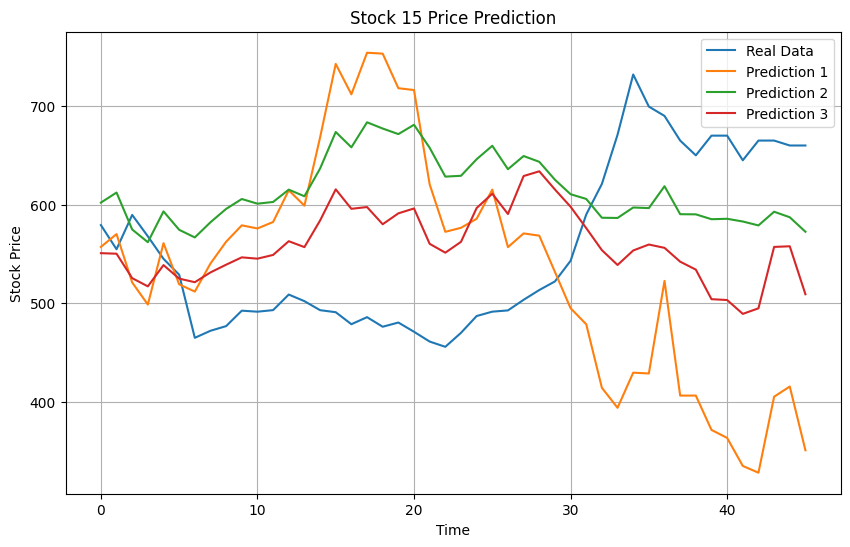

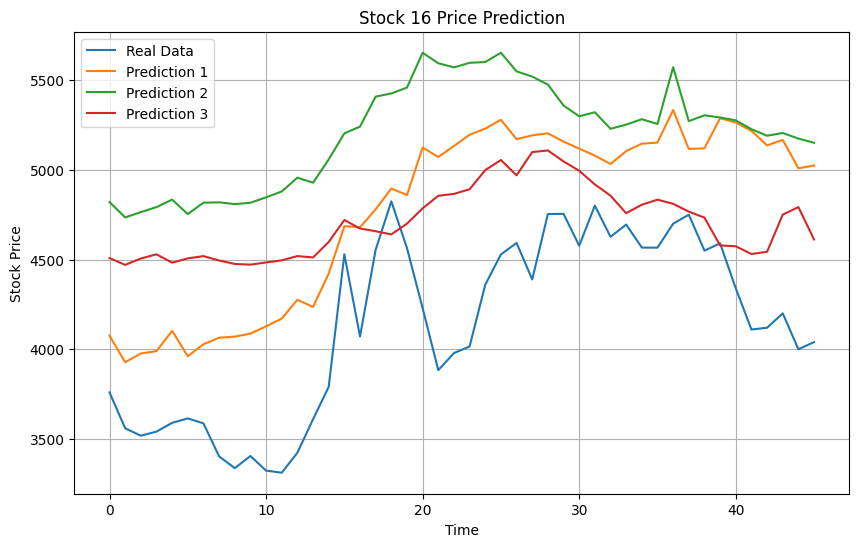

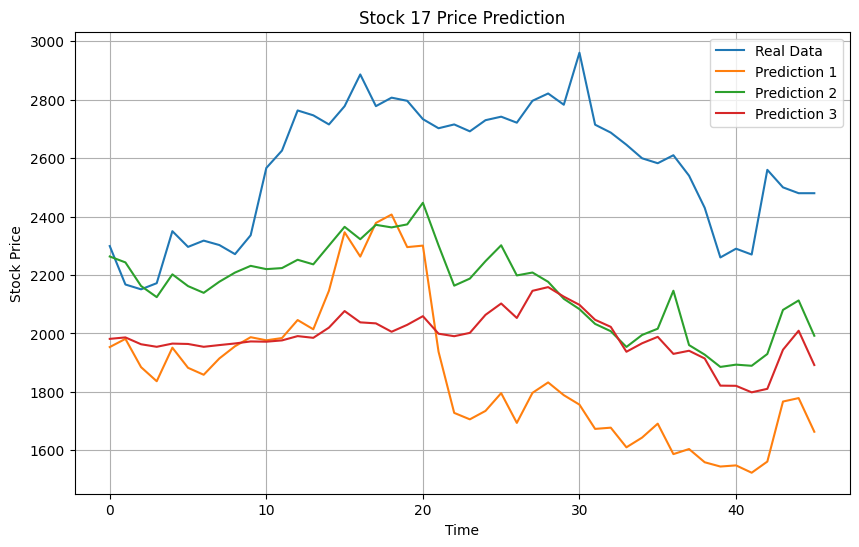

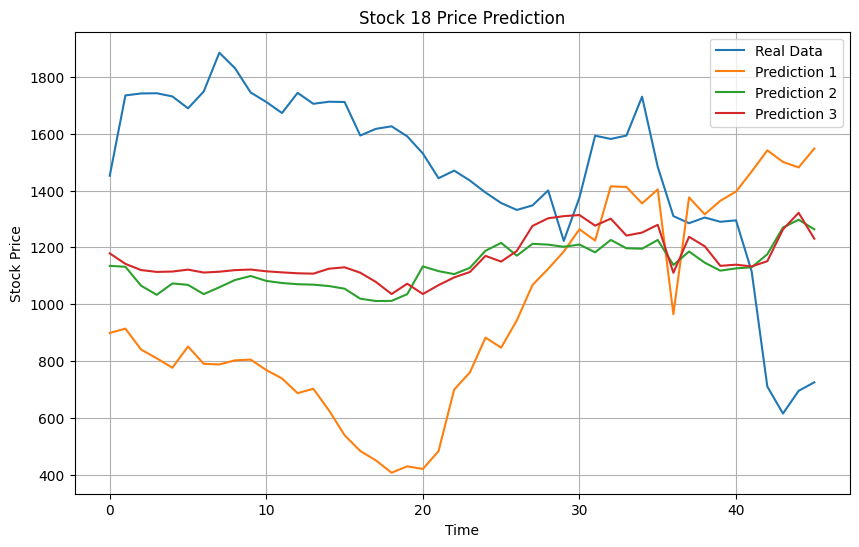

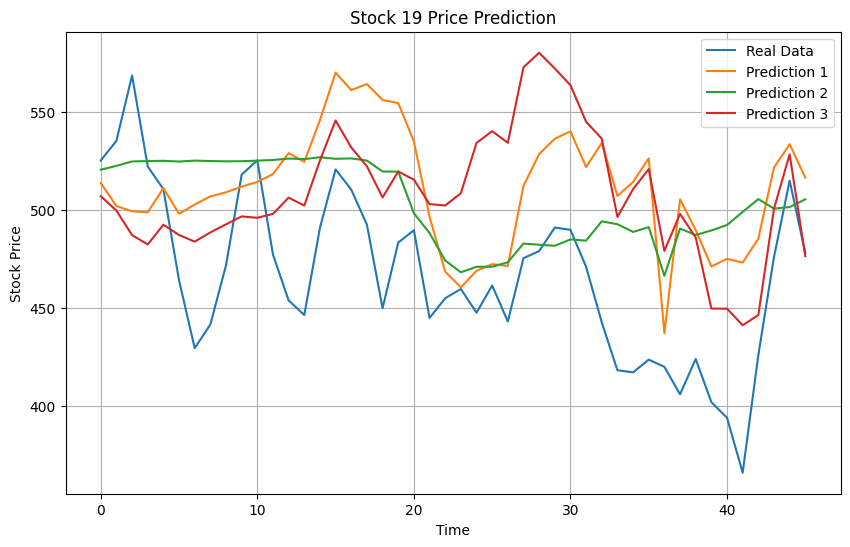

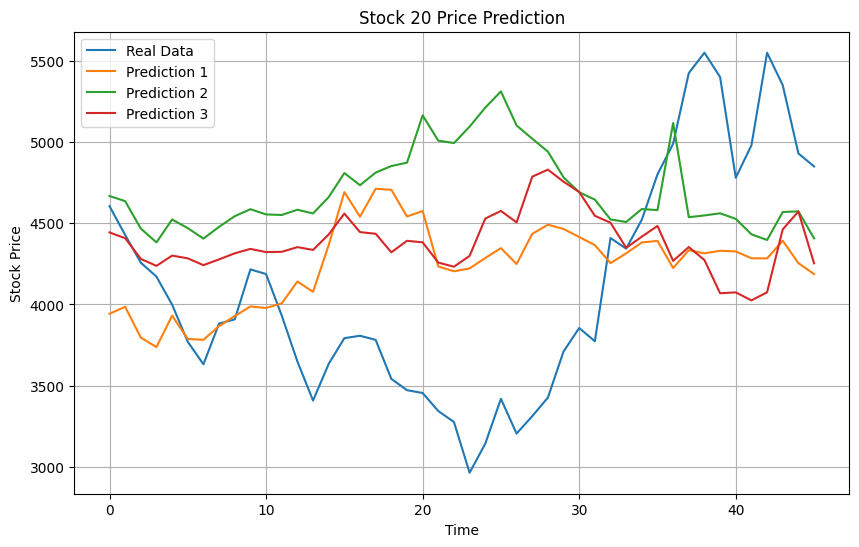

In [ ]:
for i in range(num_stocks):
    plt.figure(figsize=(10, 6))
    plt.plot(Y_Validasi[:, i], label='Real Data')
    plt.plot(Y_pred_1[:, i], label='Prediction 1')
    plt.plot(Y_pred_2[:, i], label='Prediction 2')
    plt.plot(Y_pred_3[:, i], label='Prediction 3')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title(f'Stock {i+1} Price Prediction')  # Or use actual stock names
    plt.legend()
    plt.grid(True)
    plt.show()

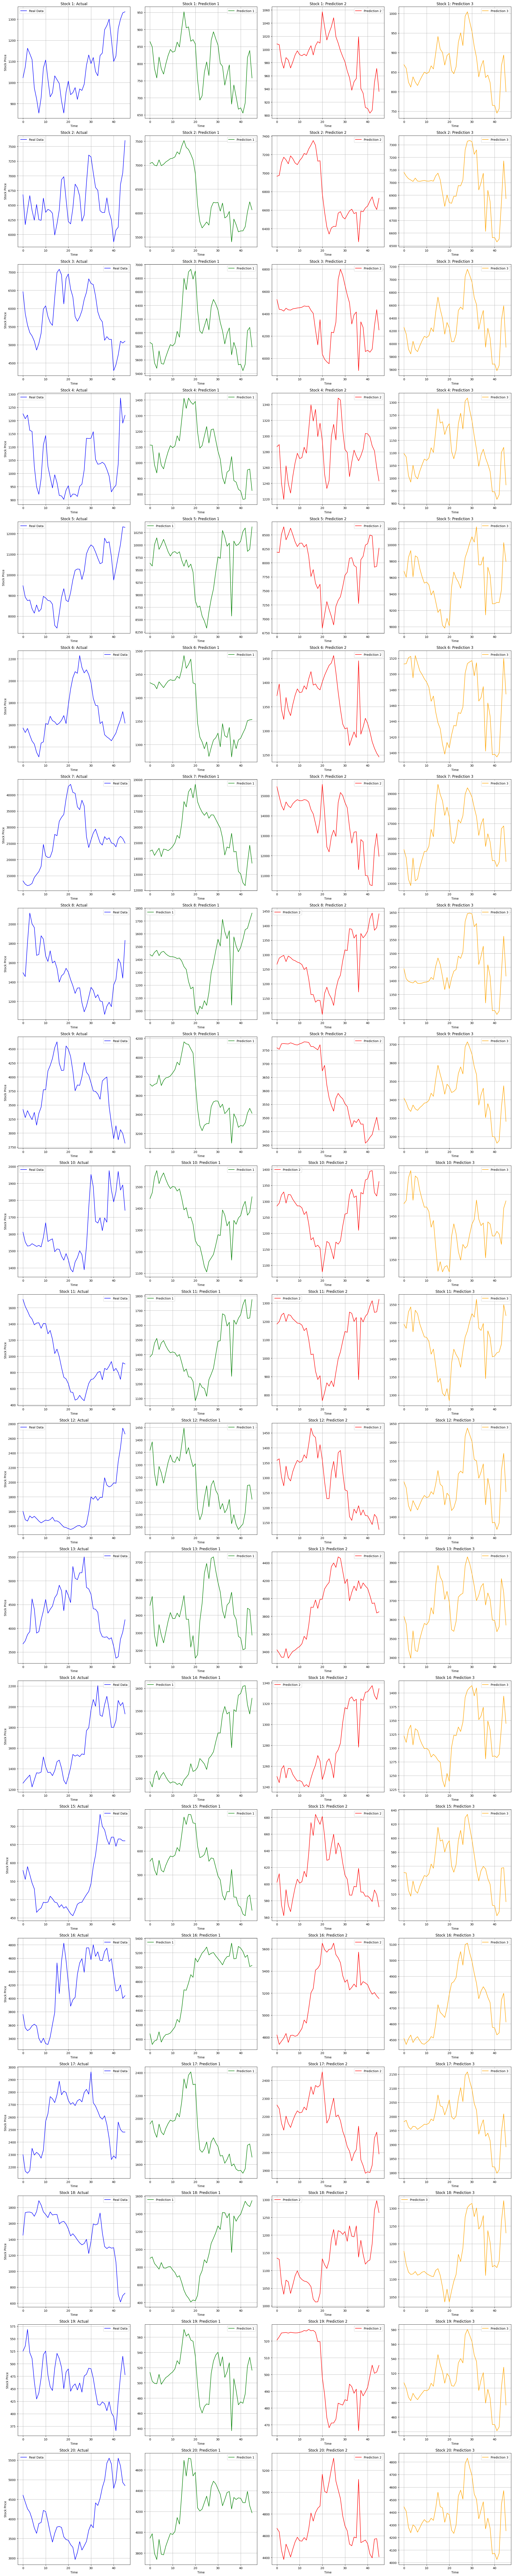

In [ ]:
# Initialize a figure to collect all subplots
fig_all, axes_all = plt.subplots(num_stocks, 4, figsize=(24, num_stocks * 6), sharey=False)

for i in range(num_stocks):
    # Plot Actual Data
    axes_all[i, 0].plot(Y_Validasi[:, i], label='Real Data', color='blue')
    axes_all[i, 0].set_title(f'Stock {i+1}: Actual')
    axes_all[i, 0].set_xlabel('Time')
    axes_all[i, 0].set_ylabel('Stock Price')
    axes_all[i, 0].grid(True)
    axes_all[i, 0].legend()

    # Plot Linear Model Predictions
    axes_all[i, 1].plot(Y_pred_1[:, i], label='Prediction 1', color='green')
    axes_all[i, 1].set_title(f'Stock {i+1}: Prediction 1')
    axes_all[i, 1].set_xlabel('Time')
    axes_all[i, 1].grid(True)
    axes_all[i, 1].legend()

    axes_all[i, 2].plot(Y_pred_2[:, i], label='Prediction 2', color='red')
    axes_all[i, 2].set_title(f'Stock {i+1}: Prediction 2')
    axes_all[i, 2].set_xlabel('Time')
    axes_all[i, 2].grid(True)
    axes_all[i, 2].legend()

    axes_all[i, 3].plot(Y_pred_3[:, i], label='Prediction 3', color='orange')
    axes_all[i, 3].set_title(f'Stock {i+1}: Prediction 3')
    axes_all[i, 3].set_xlabel('Time')
    axes_all[i, 3].grid(True)
    axes_all[i, 3].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Save the combined plots as a high-resolution image
output_path = "/content/stock_predictions_combined.png"
plt.savefig(output_path, dpi=300)
plt.show()

In [ ]:
data_baru = np.array([[15000, 4.90, 3.54]])
#data_baru = np.array([[15569.15, 6.25, 2.12]])
data_baru_standarisasi = skala_X.transform(data_baru)

prediksi_standarisasi = best_model_v5.predict(data_baru_standarisasi)
prediksi = skala_Y.inverse_transform(prediksi_standarisasi)

saham = ['Close CTRA', 'Close INDF', 'Close ASII', 'Close BSDE', 'Close ICBP',
          'Close KLBF', 'Close ITMG', 'Close JPFA', 'Close TLKM', 'Close ULTJ','Close ACES', 'Close TSPC',
          'Close SMAR', 'Close SMSM', 'Close JRPT', 'Close DUTI', 'Close EPMT', 'Close SMCB', 'Close PWON', 'Close JSMR']
hasil_prediksi = dict(zip(saham, prediksi[0]))

print("Prediksi Harga Saham Berdasarkan Data Baru:")
for stock, price in hasil_prediksi.items():
    print(f"{stock}: {price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Prediksi Harga Saham Berdasarkan Data Baru:
Close CTRA: 902.35
Close INDF: 7150.39
Close ASII: 6570.74
Close BSDE: 1153.61
Close ICBP: 9904.84
Close KLBF: 1478.03
Close ITMG: 17642.99
Close JPFA: 1559.75
Close TLKM: 3568.26
Close ULTJ: 1434.64
Close ACES: 1485.94
Close TSPC: 1510.84
Close SMAR: 3734.47
Close SMSM: 1371.22
Close JRPT: 571.73
Close DUTI: 4876.04
Close EPMT: 2030.10
Close SMCB: 1214.34
Close PWON: 537.52
Close JSMR: 4459.44


In [ ]:
joblib.dump(skala_X, 'skala_X.pkl')
joblib.dump(skala_Y, 'skala_Y.pkl')

['skala_Y.pkl']

In [ ]:
X_mean = skala_X.mean_
X_std_dev = skala_X.scale_
Y_mean = skala_Y.mean_
Y_std_dev = skala_Y.scale_
print("Mean dari X (fitur):", X_mean)
print("Standard Deviation dari X (fitur):", X_std_dev)
print("Mean dari Y (target):", Y_mean)
print("Standard Deviation dari Y (target):", Y_std_dev)

Mean dari X (fitur): [1.13554006e+04 6.87637363e+00 5.80549451e+00]
Standard Deviation dari X (fitur): [2.18573920e+03 2.00527245e+00 3.47013958e+00]
Mean dari Y (target): [  756.56801876  5193.63235726  5413.11479578  1195.75825778
  4945.55151192   981.87963331 21026.94834226   885.75037443
  2531.49913682   706.88236075   689.21839222  1701.41225076
  4612.81421489   715.46109365   522.95688386  3298.40195546
  1784.77520685  1518.8888086    323.7037573   4194.73225673]
Standard Deviation dari Y (target): [  414.05855355  2407.47856647  2484.39685086   500.92074435
  3551.56435173   594.08295758 13860.06659865   636.41417857
  1020.87809008   530.14238177   522.91937569   914.59058675
  1741.58445717   516.46851699   312.13512149  2053.81738656
  1032.81543965   786.31155433   219.5779197   1629.23022188]


In [ ]:
# Convert the Keras model to the SavedModel format
model_path = "/content/best_model_v3.keras"
loaded_model = tf.keras.models.load_model(model_path)
export_path = "/content/best_model_v3_savedmodel"
tf.saved_model.save(loaded_model, export_path)


# Create a zip archive of the SavedModel directory
zip_filename = "/content/best_model_v3.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
  for root, _, files in os.walk(export_path):
    for file in files:
      zipf.write(os.path.join(root, file),
                 os.path.relpath(os.path.join(root, file),
                                 export_path))

In [ ]:
# Convert the SavedModel to TensorFlow.js format
!tensorflowjs_converter --input_format=tf_saved_model /content/best_model_v3_savedmodel /content/tfjs_model

# Create a zip archive of the tfjs model directory
import zipfile
import os

zip_filename = "/content/tfjs_model.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
  for root, _, files in os.walk("/content/tfjs_model"):
    for file in files:
      zipf.write(os.path.join(root, file),
                 os.path.relpath(os.path.join(root, file),
                                 "/content/tfjs_model"))

2024-11-28 11:30:03.709120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732793403.807584  141993 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732793403.845375  141993 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-11-28 11:30:12.997688: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1732793413.366516  141993 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [ ]:
# Load the .pkl files
skala_X = joblib.load('/content/skala_X.pkl')
skala_Y = joblib.load('/content/skala_Y.pkl')

# Convert to dictionaries
skala_X_dict = {
    'mean': skala_X.mean_.tolist(),
    'scale': skala_X.scale_.tolist()
}

skala_Y_dict = {
    'mean': skala_Y.mean_.tolist(),
    'scale': skala_Y.scale_.tolist()
}

# Save as JSON files
with open('skala_X.json', 'w') as f:
    json.dump(skala_X_dict, f)

with open('skala_Y.json', 'w') as f:
    json.dump(skala_Y_dict, f)